In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import gensim as gs
import tensorflow as tf
import matplotlib.pyplot as plt
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()
from sklearn.metrics import accuracy_score

In [2]:
read_file = pd.read_csv('dataset/new_train_dataset_1_5', delimiter=',', header=None)
train_dataset = read_file.iloc[:,:].values

In [3]:
read_file = pd.read_csv('dataset/new_validation_dataset_1_5', delimiter=',', header=None)
validation_dataset = read_file.iloc[:,:].values

In [4]:
def sequence_padding(X_DIM, value):
    
    value_padding = np.pad(value, ((0,9 - X_DIM),(0,0)), 'constant')
    
    return value_padding

In [5]:
embedding_model = gs.models.FastText.load_fasttext_format('pre_trained_models/cc.en.300.bin')

/home/lss9/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `load_fasttext_format` (use load_facebook_vectors (to use pretrained embeddings) or load_facebook_model (to continue training with the loaded full model, more RAM) instead).
  """Entry point for launching an IPython kernel.
/home/lss9/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [6]:
left_train = []
rigth_train = []
label = []

for articleID, articleTitle, tableID, tableTitle, match in tqdm(train_dataset):
    
    value1 = tknzr.tokenize(str(articleTitle))
    
    if len(value1) < 9:
        
        embedding1 = embedding_model.wv[value1]
        padding_embedding1 = sequence_padding(embedding1.shape[0],embedding1)
        left_train.append(padding_embedding1)
    
    else:
        
        embedding1 = embedding_model.wv[value1[0:9]]
        left_train.append(embedding1)
    
    
    value2 = tknzr.tokenize(str(tableTitle))
    
    if len(value2) < 9:
        
        embedding2 = embedding_model.wv[value2]
        padding_embedding2 = sequence_padding(embedding2.shape[0],embedding2)
        rigth_train.append(padding_embedding2)
    
    else:
        
        embedding2 = embedding_model.wv[value2[0:9]]
        rigth_train.append(embedding2)
    
    
    label.append(match)

100%|██████████| 316183/316183 [01:06<00:00, 4788.88it/s]


In [7]:
left_train = np.array(left_train)
rigth_train = np.array(rigth_train)
label = np.array(label)

In [8]:
left_validation = []
rigth_validation = []
label_validation = []

for articleID, articleTitle, tableID, tableTitle, match in tqdm(validation_dataset):
    
    value1 = tknzr.tokenize(str(articleTitle))
    
    if len(value1) < 9:
        
        embedding1 = embedding_model.wv[value1]
        padding_embedding1 = sequence_padding(embedding1.shape[0],embedding1)
        left_validation.append(padding_embedding1)
    
    else:
        
        embedding1 = embedding_model.wv[value1[0:9]]
        left_validation.append(embedding1)
    
    
    value2 = tknzr.tokenize(str(tableTitle))
    
    if len(value2) < 9:
        
        embedding2 = embedding_model.wv[value2]
        padding_embedding2 = sequence_padding(embedding2.shape[0],embedding2)
        rigth_validation.append(padding_embedding2)
    
    else:
        
        embedding2 = embedding_model.wv[value2[0:9]]
        rigth_validation.append(embedding2)
    
    
    label_validation.append(match)

100%|██████████| 16623/16623 [00:02<00:00, 5944.13it/s]


In [9]:
left_validation = np.array(left_validation)
rigth_validation = np.array(rigth_validation)
label_validation = np.array(label_validation)

In [16]:
def siamese_model(input_shape):
    
    left = tf.keras.Input(input_shape)
    right = tf.keras.Input(input_shape)
    
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.Conv1D(16, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='sigmoid'))
    
    left_encoded = model(left)
    right_encoded = model(right)
    
    L1_distance = tf.keras.layers.dot([left_encoded,right_encoded], axes=1, normalize=True)
    
    prediction = tf.keras.layers.Dense(1,activation='sigmoid')(L1_distance)
    
    siamese_net = tf.keras.Model(inputs=[left,right],outputs=prediction)
    
    return siamese_net

In [17]:
model = siamese_model((9,300))

In [18]:
model.compile(loss="binary_crossentropy",optimizer="adam", metrics=['accuracy'])

In [ ]:
history = model.fit([left_train, rigth_train], label, 
          epochs=10, 
          batch_size=32, 
          validation_data=([left_validation, rigth_validation], label_validation))

Train on 316183 samples, validate on 16623 samples
Epoch 1/10
316183/316183 [==============================] - 84s 265us/sample - loss: 0.3145 - accuracy: 0.8753 - val_loss: 0.4606 - val_accuracy: 0.8012
Epoch 2/10
316183/316183 [==============================] - 41s 129us/sample - loss: 0.2393 - accuracy: 0.9162 - val_loss: 0.5332 - val_accuracy: 0.8012
Epoch 3/10
316183/316183 [==============================] - 34s 108us/sample - loss: 0.2254 - accuracy: 0.9191 - val_loss: 0.3273 - val_accuracy: 0.8784
Epoch 4/10
316183/316183 [==============================] - 29s 93us/sample - loss: 0.2175 - accuracy: 0.9220 - val_loss: 0.4488 - val_accuracy: 0.8168
Epoch 5/10
316183/316183 [==============================] - 31s 97us/sample - loss: 0.2122 - accuracy: 0.9232 - val_loss: 0.5937 - val_accuracy: 0.8025
Epoch 6/10
316183/316183 [==============================] - 30s 96us/sample - loss: 0.2080 - accuracy: 0.9247 - val_loss: 0.6584 - val_accuracy: 0.8014
Epoch 7/10
316183/316183 [========

In [ ]:
model.save('model_siamese_conv1d.h5')

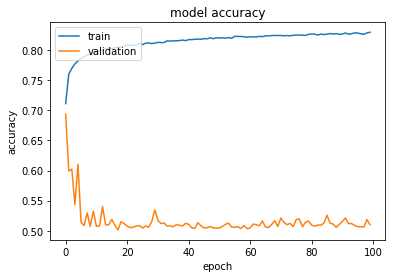

In [18]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

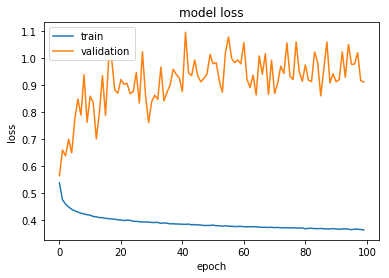

In [19]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [20]:
y_prob = model.predict([left_test,rigth_test])

In [21]:
y_prob[y_prob >= 0.5] = 1

In [22]:
y_prob[y_prob < 0.5] = 0

In [23]:
accuracy_score(label_test, y_prob)

0.5091857564073486